<a href="https://colab.research.google.com/github/bee20/Time-Series-Forecasting/blob/main/KAGGLE_SALES_FORECAST_COMPET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
# link to kaggle data - https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

In [53]:
!pip install pmdarima

In [54]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
## create a SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from datetime import datetime

import matplotlib.pyplot as plt

In [55]:
holiday = pd.read_csv("holidays_events.csv")
holiday['holiday'] = 1
holiday['date'] = pd.to_datetime(holiday['date'])

holiday

,date,type,locale,locale_name,description,transferred,holiday
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,1
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,1
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,1
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,1
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,1
...,...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False,1
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False,1
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False,1
348,2017-12-25,Holiday,National,Ecuador,Navidad,False,1


In [56]:
df_full = pd.read_csv("train.csv")
df_full['date'] = pd.to_datetime(df_full['date'])
df_full = df_full[df_full['family'] == 'GROCERY I']
df_full = df_full.groupby(['date'])['sales'].sum().reset_index()

df= df_full.copy()
df = df[df['date']>= pd.to_datetime('2013-01-06')]
print(len(df))
print(df['date'].min(), df['date'].max())

per1 = pd.date_range(start = df['date'].min(),
         end = df['date'].max(), freq ='D')
skeleton = pd.DataFrame({'date': per1.to_list()})
avg = df['sales'].mean()
df = pd.merge( skeleton, df, on='date', how = 'left').fillna( avg )
print(len(df))

# bring in exogenous variable
df = pd.merge(df, holiday[['date','holiday']].drop_duplicates(), on ='date', how = 'left')
df['holiday'] = df['holiday'].fillna(0)
print(len(df))
print(df['holiday'].unique())

df.set_index("date", inplace = True)

df_train = df.head(1400)
df_test = df.tail(283)

df.sort_values(['date'])
print(len(df), len(df_train), len(df_test)   )

383
2013-01-06 00:00:00 2014-01-24 00:00:00
384
384
[0. 1.]
384 384 283


In [113]:
# Computing IQR
Q1 = df['sales'].quantile(0.25)
Q3 = df['sales'].quantile(0.75)
IQR = Q3 - Q1
lb = Q1 - 1.5*IQR
ub = Q3 + 1.5*IQR
df['Outlier'] = np.where( (df['sales'] < lb ), 1, 0 )
df['Outlier'] = np.where( (df['sales'] > ub ), 1, df['Outlier'])

df['Outlier'].sum()

6

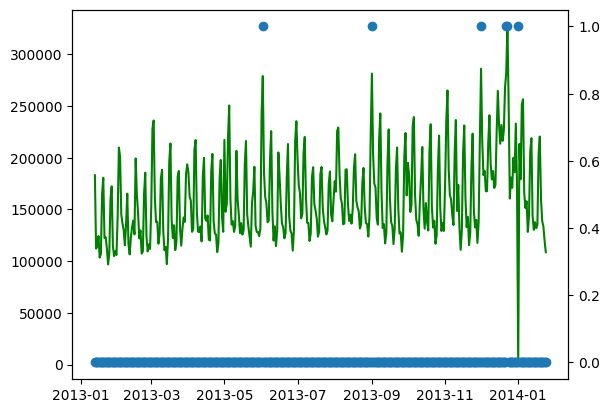

In [123]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(df[['sales']], 'g')
ax2.scatter(df.index, df[['Outlier']])

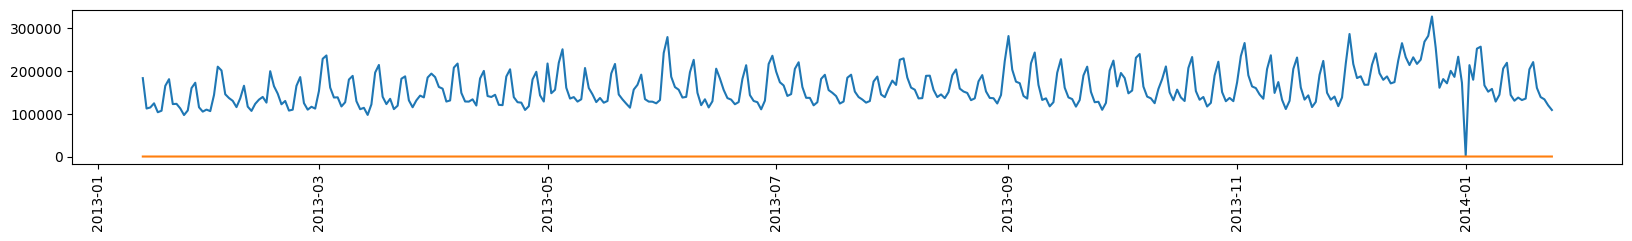

In [116]:
# df.columns
plt.figure(figsize=(20, 2))
plt.xticks(rotation=90)
plt.plot(df[['sales']])

# looks like seasonality is there and trend is there -> check stationarity

In [58]:
df['df_diff'] = df['sales'] - df['sales'].shift(7)
print(len(df))
df = df.dropna()
print(len(df))
fuller = adfuller( df['sales'] )
print("ADF stat is ", fuller[0])
print("p value is ", fuller[1])

384
377
ADF stat is  -3.145657058966618
p value is  0.02335373973083898


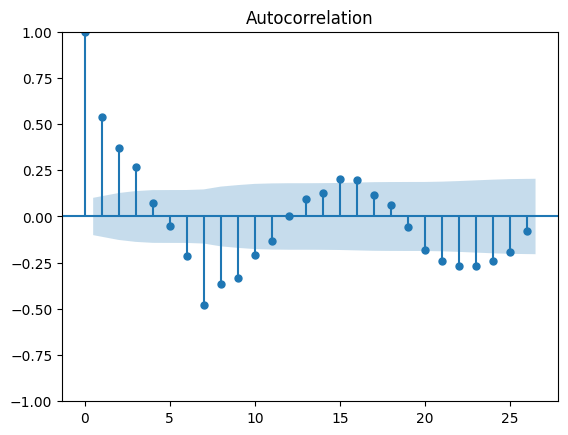

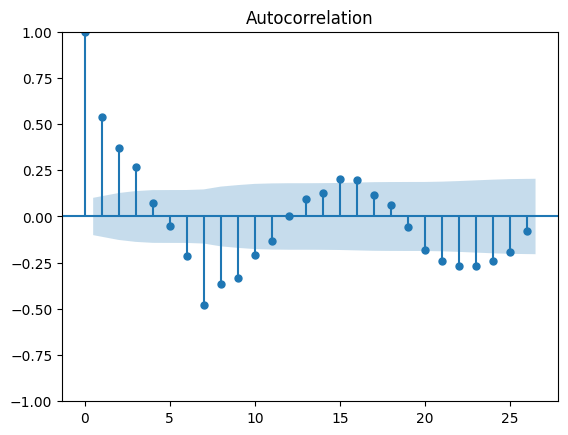

In [59]:
 plot_acf(df['df_diff'])


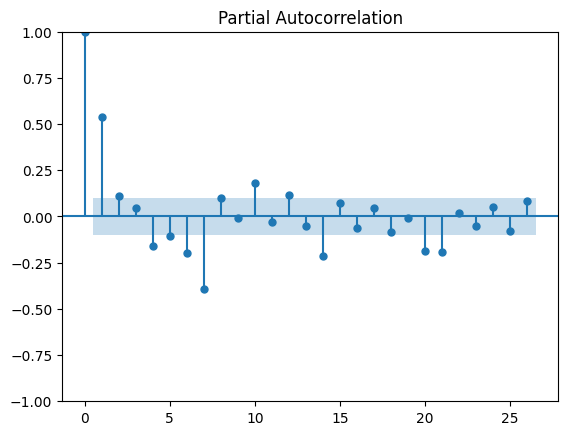

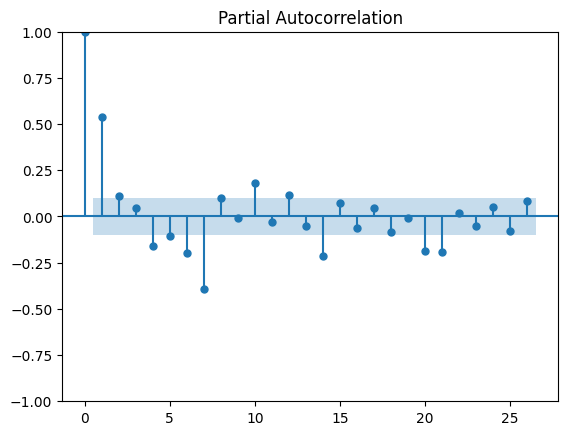

In [60]:
plot_pacf(df['df_diff'])

In [61]:
# ARIMA(P,D,Q) = ARIMA(3,0,1)

import pmdarima as pm
model = pm.auto_arima(df_train['sales'], exogenous= df_train['holiday'])
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  384
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4605.036
Date:                Fri, 28 Jun 2024   AIC                           9212.072
Time:                        11:58:05   BIC                           9216.020
Sample:                    01-06-2013   HQIC                          9213.639
                         - 01-24-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.622e+09   8.08e+07     20.077      0.000    1.46e+09    1.78e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                79.54
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               1.62   Skew:                             0.21
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
sarimamodel = SARIMAX(df_train['sales'], order=((3,1,4)		 ))
model_sArima_fit = sarimamodel.fit()

sarimamodel_ex = SARIMAX(df_train['sales'], exog= df_train['holiday'],  order=((5, 1, 5)		 ))
model_sArima_fit_ex = sarimamodel_ex.fit()


display(model_sArima_fit.summary(), model_sArima_fit_ex.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeli

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                  384
Model:               SARIMAX(3, 1, 4)   Log Likelihood               -4506.560
Date:                Fri, 28 Jun 2024   AIC                           9029.119
Time:                        11:58:14   BIC                           9060.703
Sample:                    01-06-2013   HQIC                          9041.648
                         - 01-24-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1823      0.066      2.776      0.006       0.054       0.311
ar.L2         -0.7392      0.076     -9.716      0.000      -0.888      -0.590
ar.L3          0.1722      0.081      2.137      0.033       0.014       0.330
ma.L1         -0.4826      0.064     -7.587      0.000      -0.607      -0.358
ma.L2          0.3721      0.080      4.672      0.000       0.216       0.528
ma.L3         -0.2650      0.086     -3.064      0.002      -0.434      -0.095
ma.L4         -0.5547      0.061     -9.132      0.000      -0.674      -0.436
sigma2      1.104e+09   2.36e-11   4.68e+19      0.000     1.1e+09     1.1e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):                76.72
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               1.78   Skew:                             0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.12e+36. Standard errors may be unstable.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                  384
Model:               SARIMAX(5, 1, 5)   Log Likelihood               -4396.288
Date:                Fri, 28 Jun 2024   AIC                           8816.577
Time:                        11:58:14   BIC                           8863.953
Sample:                    01-06-2013   HQIC                          8835.370
                         - 01-24-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday     9011.5035   4865.193      1.852      0.064    -524.100    1.85e+04
ar.L1          1.3507      0.070     19.313      0.000       1.214       1.488
ar.L2         -1.8750      0.062    -30.346      0.000      -1.996      -1.754
ar.L3          1.5722      0.099     15.906      0.000       1.379       1.766
ar.L4         -1.4144      0.053    -26.796      0.000      -1.518      -1.311
ar.L5          0.5368      0.063      8.486      0.000       0.413       0.661
ma.L1         -1.7341      0.055    -31.666      0.000      -1.841      -1.627
ma.L2          2.1636      0.086     25.243      0.000       1.996       2.332
ma.L3         -2.0552      0.095    -21.652      0.000      -2.241      -1.869
ma.L4          1.6047      0.069     23.129      0.000       1.469       1.741
ma.L5         -0.8502      0.050    -16.958      0.000      -0.948      -0.752
sigma2      6.697e+08      0.053   1.26e+10      0.000     6.7e+08     6.7e+08
===================================================================================
Ljung-Box (L1) (Q):                   4.21   Jarque-Bera (JB):              3061.66
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               2.21   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.44e+25. Standard errors may be unstable.
"""

In [63]:
arimamodel = ARIMA(df_train['sales'], order=(5, 1, 5))
model_Arima_fit = arimamodel.fit()
model_Arima_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                  384
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -4396.031
Date:                Fri, 28 Jun 2024   AIC                           8814.063
Time:                        11:58:21   BIC                           8857.491
Sample:                    01-06-2013   HQIC                          8831.290
                         - 01-24-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2664      0.070     18.084      0.000       1.129       1.404
ar.L2         -1.8075      0.059    -30.437      0.000      -1.924      -1.691
ar.L3          1.4554      0.098     14.856      0.000       1.263       1.647
ar.L4         -1.3527      0.051    -26.486      0.000      -1.453      -1.253
ar.L5          0.4537      0.063      7.199      0.000       0.330       0.577
ma.L1         -1.7513      0.049    -35.558      0.000      -1.848      -1.655
ma.L2          2.1739      0.074     29.404      0.000       2.029       2.319
ma.L3         -2.0647      0.085    -24.207      0.000      -2.232      -1.898
ma.L4          1.6487      0.060     27.405      0.000       1.531       1.767
ma.L5         -0.8507      0.044    -19.426      0.000      -0.937      -0.765
sigma2       6.78e+08   4.06e-11   1.67e+19      0.000    6.78e+08    6.78e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2021.97
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.94e+35. Standard errors may be unstable.
"""

<Axes: ylabel='Density'>

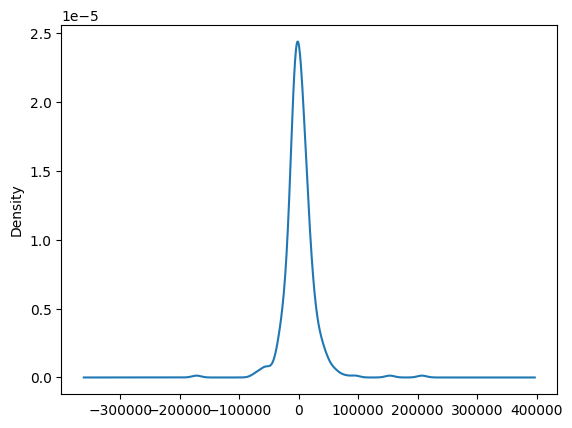

In [64]:
model_sArima_fit_ex.resid.plot(kind='kde')

In [65]:
pred_start_date=df_test.index[0]
pred_end_date=df_test.index[-1]
print(pred_start_date)
print(pred_end_date)

2013-04-17 00:00:00
2014-01-24 00:00:00


In [66]:
##prediction
pred = model_Arima_fit.predict(pred_start_date, pred_end_date  )

preds = model_sArima_fit.predict(pred_start_date, pred_end_date  )
preds_ex = model_sArima_fit_ex.predict(pred_start_date , pred_end_date, exog = df_test['holiday'])

In [67]:

df_test['Predicted_ARIMA']=pred
df_test['Predicted_SARIMA']=preds
df_test['Predicted_SARIMA_EXOG']=preds_ex

display( df_test)


,sales,holiday,Predicted_ARIMA,Predicted_SARIMA,Predicted_SARIMA_EXOG
date,,,,,
2013-04-17,144229.000,0.0,144731.509397,155439.262105,139182.157694
2013-04-18,120743.000,0.0,132244.295189,124343.314376,124311.375334
2013-04-19,120012.000,0.0,137137.620626,121957.504023,132788.595676
2013-04-20,186817.000,0.0,176376.139610,148473.745985,177037.832615
2013-04-21,203746.000,1.0,189745.831330,183438.827798,204007.522249
...,...,...,...,...,...
2014-01-20,160243.638,0.0,186645.577489,169904.943311,193678.782186
2014-01-21,138798.936,0.0,137744.434765,166615.428470,136991.367285
2014-01-22,133569.332,0.0,137618.495027,181228.409411,132421.274537


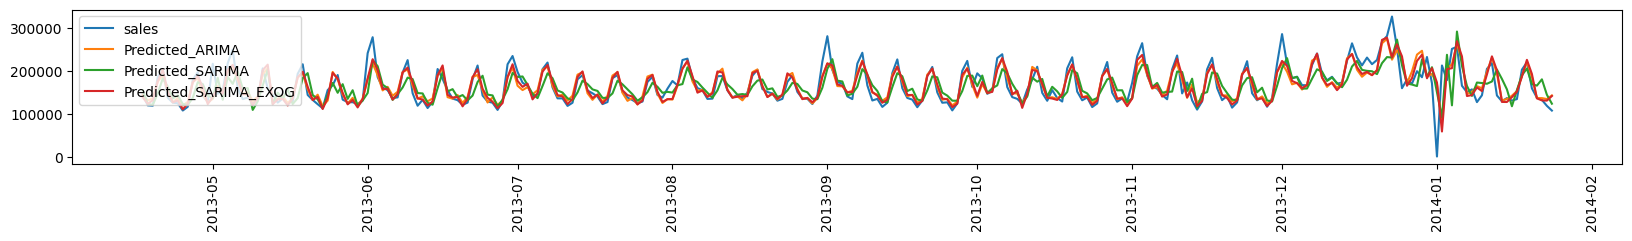

In [68]:

# df.columns
plt.figure(figsize=(20, 2))
plt.xticks(rotation=90)
plt.plot(df_test[['sales', 'Predicted_ARIMA', 'Predicted_SARIMA', 'Predicted_SARIMA_EXOG']])
plt.legend(['sales', 'Predicted_ARIMA', 'Predicted_SARIMA' , 'Predicted_SARIMA_EXOG'], loc='upper left')

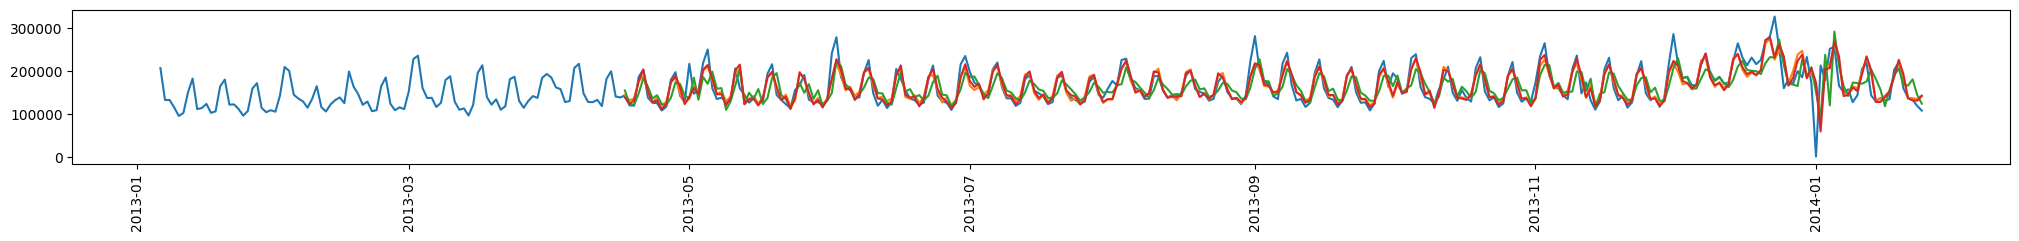

In [69]:
# df.columns
plt.figure(figsize=(25, 2))
plt.xticks(rotation=90)
plt.plot(df_train[['sales']])
plt.plot(df_test[['Predicted_ARIMA', 'Predicted_SARIMA', 'Predicted_SARIMA_EXOG']])


In [70]:
print('RMSE for ARIMA is : ', ((df_test.sales - df_test.Predicted_ARIMA) ** 2).mean() ** .5)
print('RMSE for SARIMA is :', ((df_test.sales - df_test.Predicted_SARIMA) ** 2).mean() ** .5)
print('RMSE for SARIMA with exog is : ', ((df_test.sales - df_test.Predicted_SARIMA_EXOG) ** 2).mean() ** .5)

RMSE for ARIMA is :  23675.977342999988
RMSE for SARIMA is : 32246.3985319953
RMSE for SARIMA with exog is :  23818.32422772485


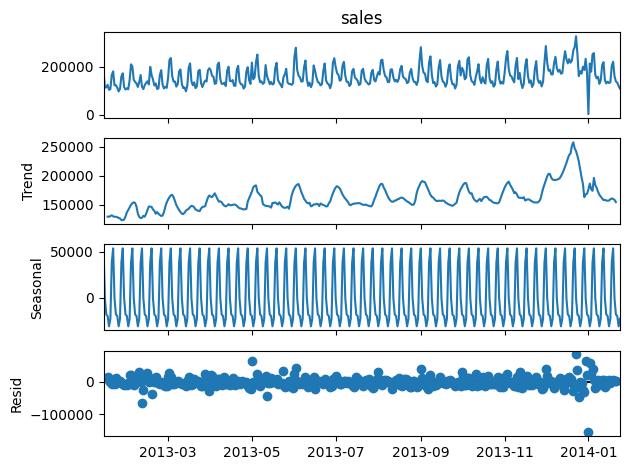

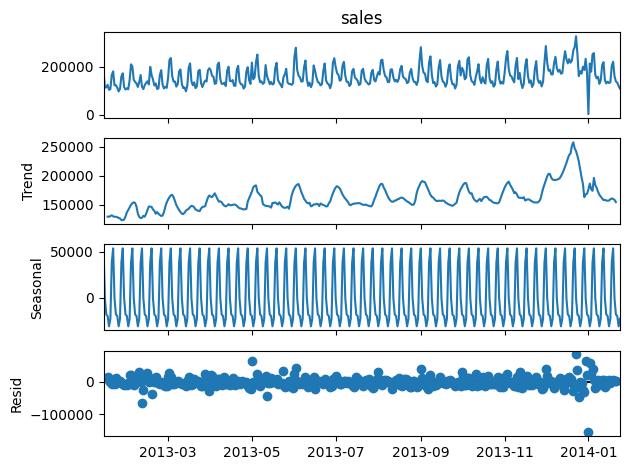

In [101]:
# segregate trend seasonal from time series
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['sales'], model='additive')

# print(result.trend)
# print(result.seasonal)
# print(result.resid)
# print(result.observed)

# plt.plot(df['sales'])
# result = seasonal_decompose(series, model='additive', period=1)
result.plot()


EXPONENTIAL SMOOTHING

In [71]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
<ipython-input-89-0628fe5cbd89>:13: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  fitH = modelH.fit(smoothing_level=1, smoothing_sl

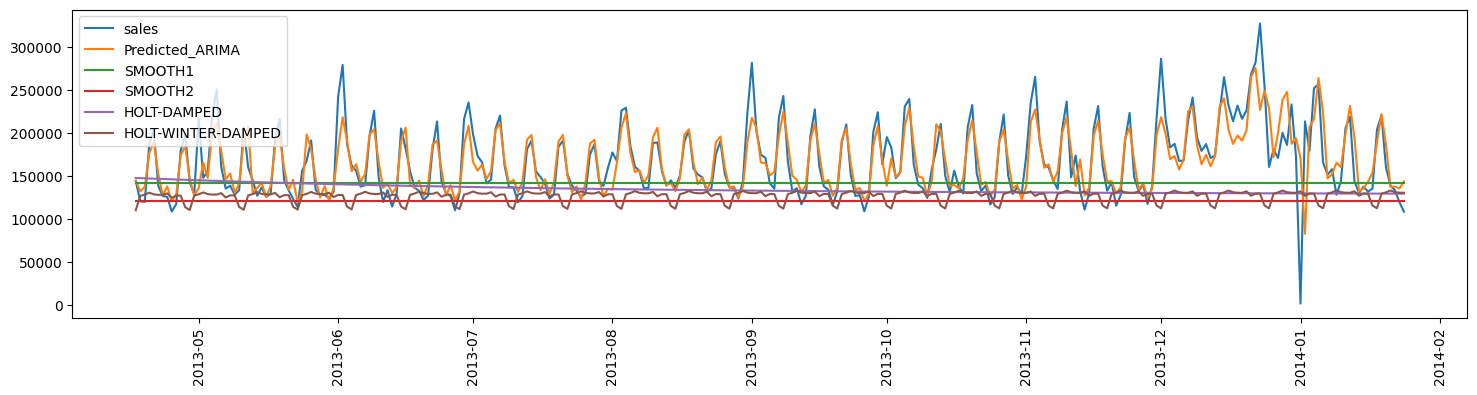

In [89]:
model_SIMPL = SimpleExpSmoothing(df_train['sales'])
fit1 = model_SIMPL.fit(smoothing_level=.2)
pred1 = fit1.forecast(len(df_test))

fit2 = model_SIMPL.fit(smoothing_level=.5)
pred2 = fit2.forecast(len(df_test))

df_test['SMOOTH1'] = pred1.values
df_test['SMOOTH2'] = pred2.values


modelH = Holt(df_train['sales'])
fitH = modelH.fit(smoothing_level=1, smoothing_slope=1)
predH = fitH.forecast(len(df_test))
df_test['SMOOTHH'] = predH.values

modelHH = ExponentialSmoothing(np.asarray(df_train['sales']), trend='mul', seasonal=None, damped=True)
fitHH = modelHH.fit()
predHH = fitHH.forecast(len(df_test))
df_test['SMOOTHHH'] = predHH

model2H = ExponentialSmoothing(df_train['sales'], trend="mul", seasonal="mul", seasonal_periods=12, damped=True)
fitHH2 = model2H.fit(smoothing_level=.5, smoothing_slope=0)
predHHH = fitHH2.forecast(len(df_test))
df_test['SMOOTHHW'] = predHHH.values

# df.columns
plt.figure(figsize=(18, 4))
plt.xticks(rotation=90)
plt.plot(df_test[['sales', 'Predicted_ARIMA', 'SMOOTH1', 'SMOOTH2',  'SMOOTHHH', 'SMOOTHHW' ]])
plt.legend(['sales', 'Predicted_ARIMA', 'SMOOTH1', 'SMOOTH2',  'HOLT-DAMPED', 'HOLT-WINTER-DAMPED'], loc='upper left')

In [90]:
# AUTO ETS MODEL
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

model = ETSModel(df_train['sales'], )
fit = model.fit(maxiter=10000)
fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                  sales   No. Observations:                  384
Model:                       ETS(ANN)   Log Likelihood               -4610.960
Date:                Fri, 28 Jun 2024   AIC                           9227.920
Time:                        12:15:27   BIC                           9239.772
Sample:                    01-06-2013   HQIC                          9232.621
                         - 01-24-2014   Scale                   1575028991.350
Covariance Type:               approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.0878      0.037      2.361      0.018       0.015       0.161
initial_level    1.557e+05   1.87e+04      8.303      0.000    1.19e+05    1.92e+05
===================================================================================
Ljung-Box (Q):                       80.79   Jarque-Bera (JB):                49.81
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

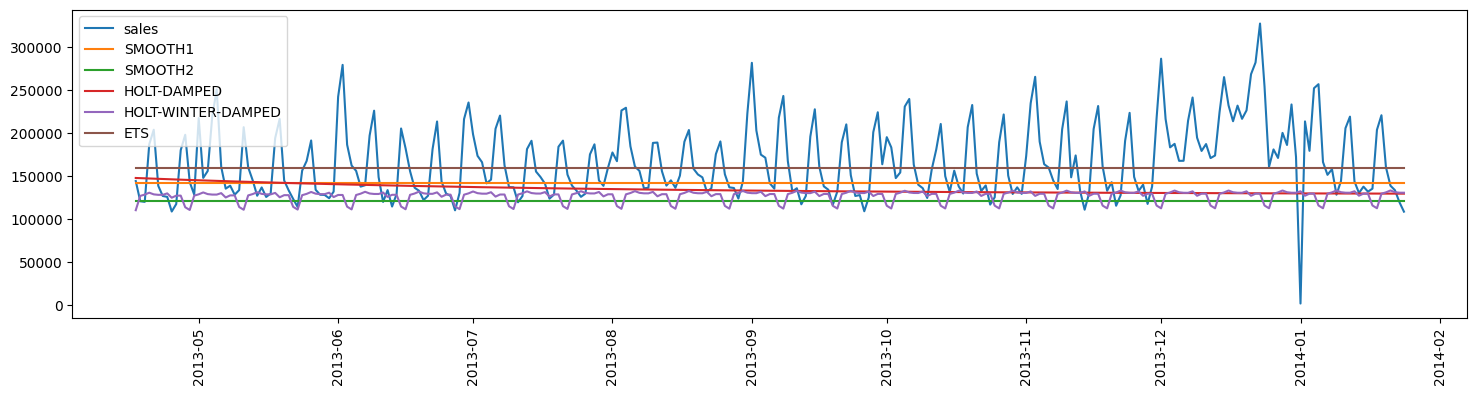

In [91]:
predETS= fit.forecast(len(df_test))
df_test['ETS'] = predETS.values

# df.columns
plt.figure(figsize=(18, 4))
plt.xticks(rotation=90)
plt.plot(df_test[['sales', 'SMOOTH1', 'SMOOTH2',  'SMOOTHHH', 'SMOOTHHW','ETS' ]])
plt.legend(['sales', 'SMOOTH1', 'SMOOTH2',  'HOLT-DAMPED', 'HOLT-WINTER-DAMPED', 'ETS'], loc='upper left')